## Open Raw & Processed Files

In [1]:
from dataset import TimeSeriesDataset

data_dir = "data"

class_N_test_ids = ['006', '011', '014', '015','016','017','021','022','024','031','039','043','046','047','048','054','055','059','063','064','066','068','070','075','076','081','090','095','096','097','098','102','103','105','106','112','123','124','125','127','128','129','135','138','140','140','141','142','144','148','149','154','158','159','163','164','166','178','179','184','189','194','196','198'] # noir pur
class_B_test_ids = ['012', '018', '019', '020','023','036','040','042','049','053','083','091','121','133','134','146','151','155','172','177','192']  # blanc pur

raw_dataset = TimeSeriesDataset(pkl_path=f"{data_dir}/raw.pkl", mode="raw", seq_length=1900)
processed_dataset = TimeSeriesDataset(pkl_path=f"{data_dir}/processed.pkl", mode="processed", seq_length=1600)

raw_dfs = raw_dataset.dfs
raw_ids = raw_dataset.ids

processed_dfs = processed_dataset.dfs
processed_ids = processed_dataset.ids

In [2]:
def get_labels(ids, class_N, class_B):
    labels = []
    for id in ids:
        if id in class_N:
            labels.append("black")
        elif id in class_B:
            labels.append("white")
        else:
            labels.append("unknown")
    return labels

raw_labels = get_labels(raw_ids, class_N_test_ids, class_B_test_ids)
processed_labels = get_labels(processed_ids, class_N_test_ids, class_B_test_ids)

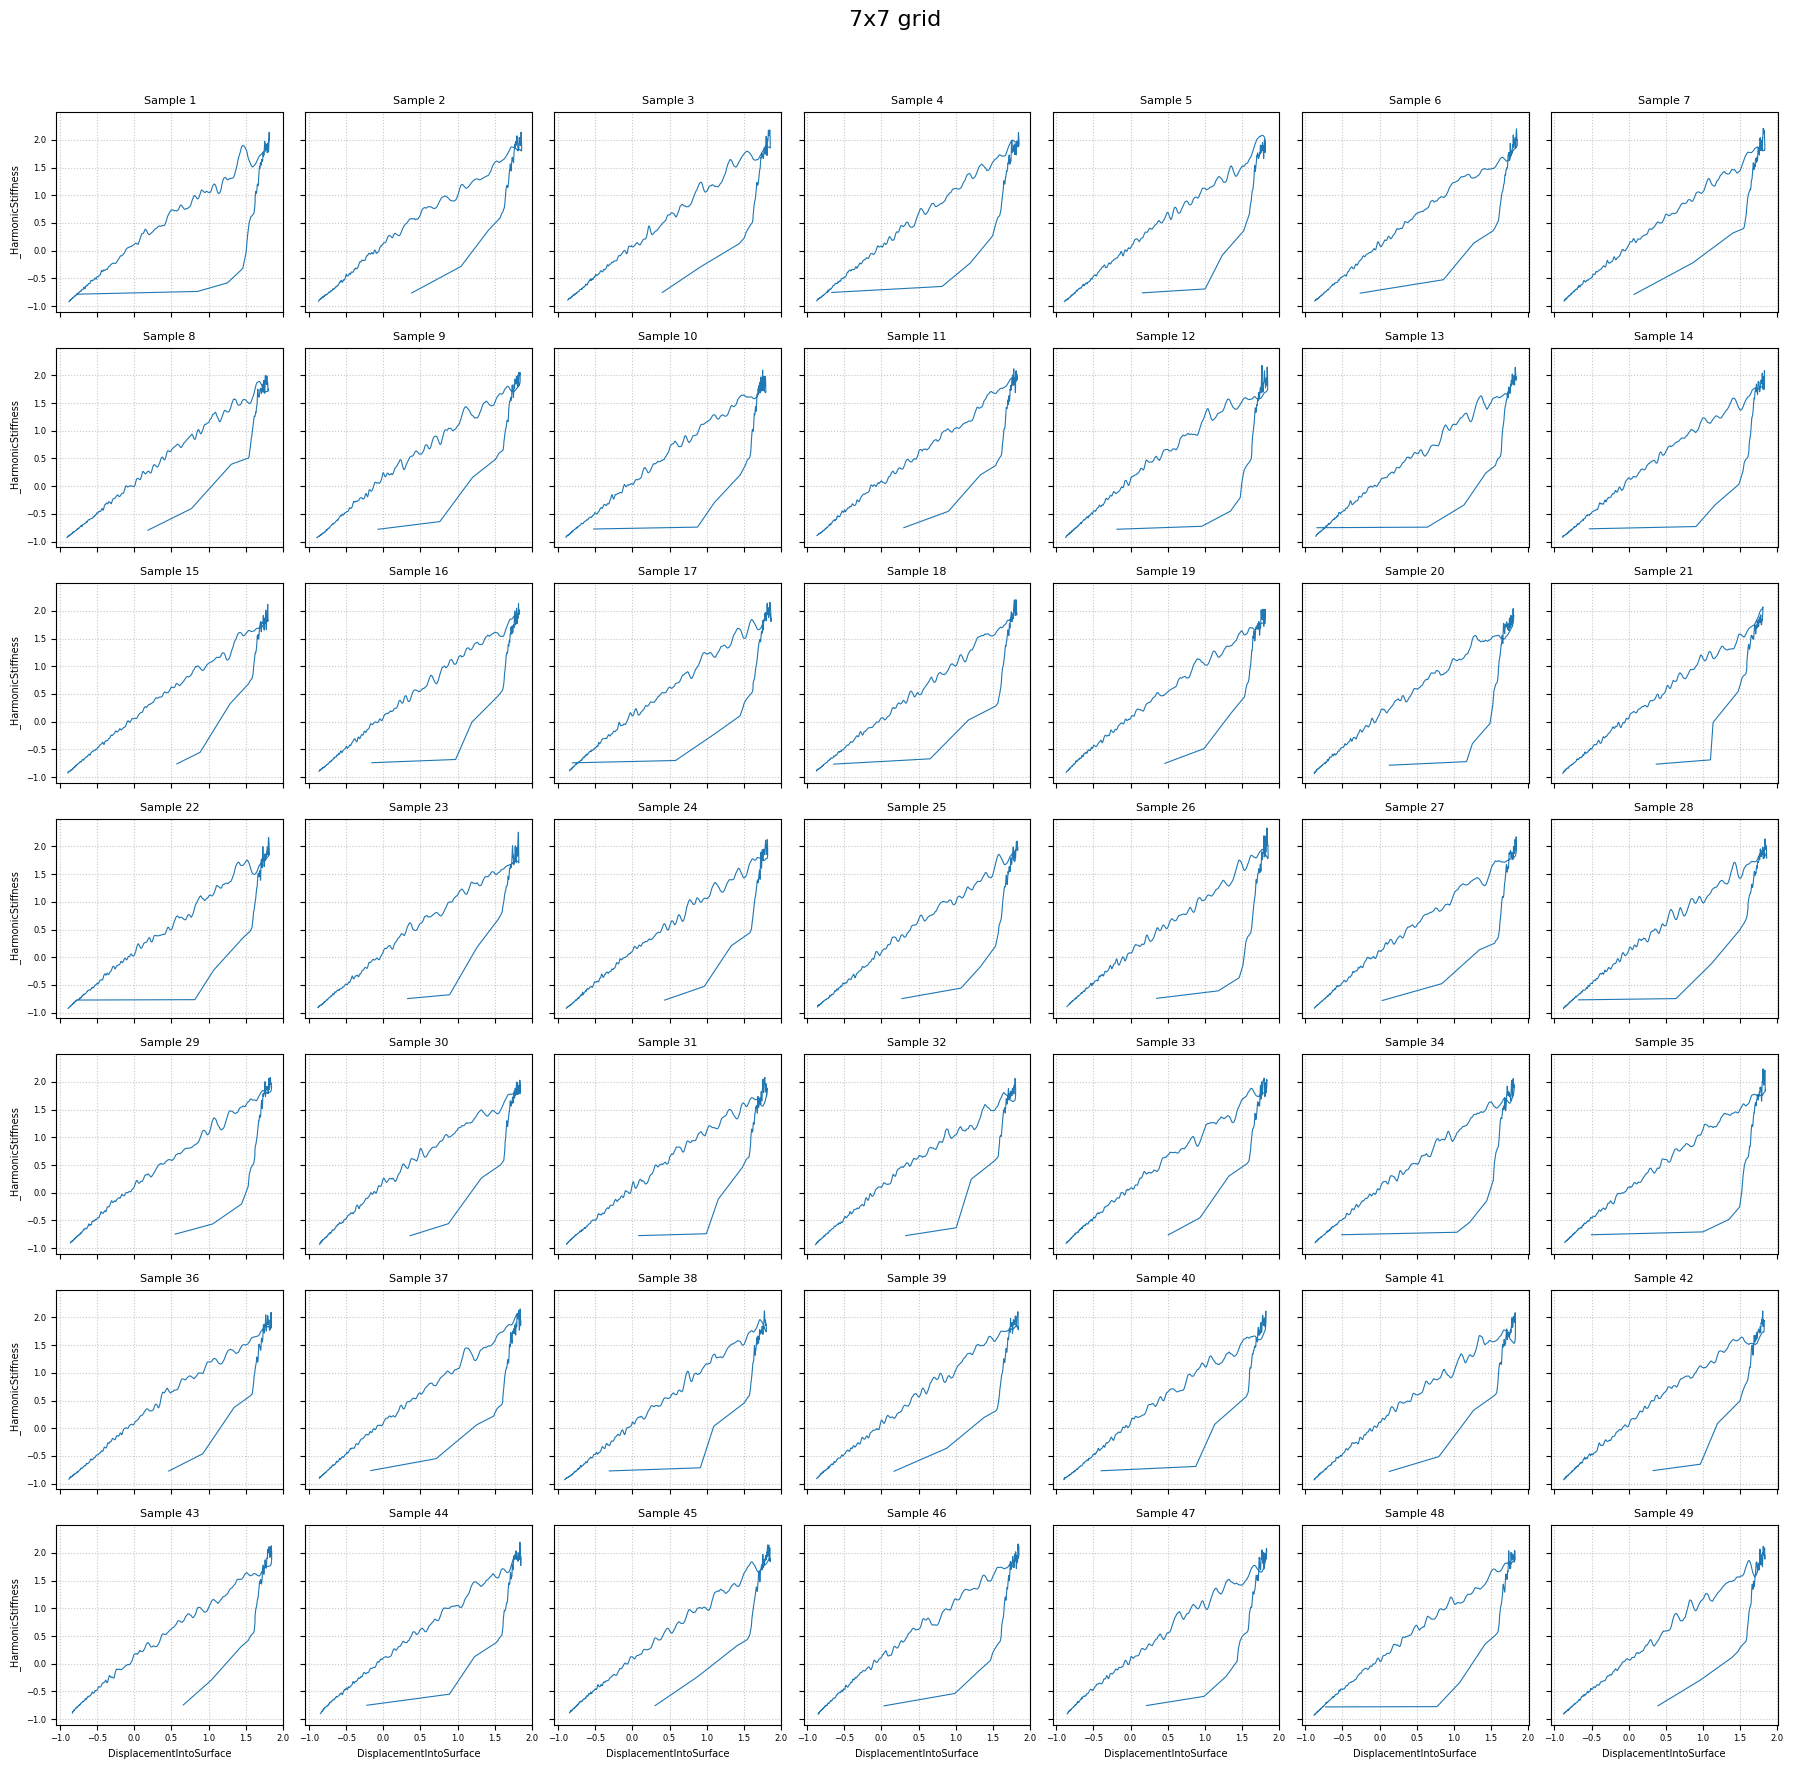

In [3]:
import matplotlib.pyplot as plt

RAW_DISPLACEMENT_COL = 'DisplacementIntoSurface'
RAW_LOAD_COL = '_HarmonicStiffness' 

grid_size = (7, 7)
num_plots = grid_size[0] * grid_size[1]

fig, axes = plt.subplots(grid_size[0], grid_size[1], figsize=(18, 18), sharex=True, sharey=True)
fig.suptitle(f'{grid_size[0]}x{grid_size[1]} grid', fontsize=16)
axes_flat = axes.flatten()

for i in range(min(len(raw_dfs), num_plots)):
    df = raw_dfs[i]
    ax = axes_flat[i]
        
    ax.plot(df[RAW_DISPLACEMENT_COL], df[RAW_LOAD_COL], linewidth=0.8)
    ax.set_title(f'Sample {i+1}', fontsize=8)
    ax.xaxis.set_tick_params(labelsize=6)
    ax.yaxis.set_tick_params(labelsize=6)

    if i // grid_size[1] == grid_size[0] - 1: 
        ax.set_xlabel(RAW_DISPLACEMENT_COL, fontsize=7)
    if i % grid_size[1] == 0: 
        ax.set_ylabel(RAW_LOAD_COL, fontsize=7)
    ax.grid(True, linestyle=':', alpha=0.7)

plt.tight_layout(rect=[0, 0, 1, 0.96]) 
plt.show()

In [4]:
from scipy.stats import skew, kurtosis
from scipy.signal import find_peaks
import numpy as np
import pandas as pd

def extract_features_from_curve(df):
    features = {}
    
    h = df['Déplacement corrigé dérive thermique (nm)'].values
    H = df['HOP (MPa)'].values

    valid = h >= 0
    h = h[valid]
    H = H[valid]

    # Corriger les problèmes de gradient (h doit être strictement croissant)
    sorted_indices = np.argsort(h)
    h = h[sorted_indices]
    H = H[sorted_indices]

    _, unique_indices = np.unique(h, return_index=True)
    h = h[unique_indices]
    H = H[unique_indices]

    if len(H) == 0:
        return {}

    features.update({
        'max_HOP': np.max(H),
        'min_HOP': np.min(H),
        'mean_HOP': np.mean(H),
        'std_HOP': np.std(H),
        'range_HOP': np.ptp(H),
        'skew_HOP': skew(H),
        'kurtosis_HOP': kurtosis(H)
    })

    dH_dh = np.gradient(H, h)
    d2H_dh2 = np.gradient(dH_dh, h)

    features.update({
        'max_abs_dH_dh': np.max(np.abs(dH_dh)),
        'mean_dH_dh': np.mean(dH_dh),
        'std_dH_dh': np.std(dH_dh),
        'max_abs_d2H_dh2': np.max(np.abs(d2H_dh2)),
        'n_peaks_dH_dh': len(find_peaks(np.abs(dH_dh))[0]),
        'n_peaks_d2H_dh2': len(find_peaks(np.abs(d2H_dh2))[0])
    })

    segment_edges = [0, 200, 500, 800, np.inf]
    for i in range(len(segment_edges) - 1):
        mask = (h >= segment_edges[i]) & (h < segment_edges[i+1])
        if np.any(mask):
            segment = H[mask]
            features.update({
                f'segment_{i}_mean_HOP': np.mean(segment),
                f'segment_{i}_std_HOP': np.std(segment),
                f'segment_{i}_max_HOP': np.max(segment),
                f'segment_{i}_min_HOP': np.min(segment),
            })

    initial_mask = h <= 50
    if np.sum(initial_mask) > 2:
        poly = np.polyfit(h[initial_mask], H[initial_mask], 1)
        features['initial_stiffness'] = poly[0]
    else:
        features['initial_stiffness'] = np.nan

    return features

features_list = []
for df in processed_dfs:
    feats = extract_features_from_curve(df)
    features_list.append(feats)

df_features = pd.DataFrame(features_list)

In [5]:
import json
import numpy as np
from ts2vec import TS2Vec

mode = "processed"
labels = processed_labels if mode == "processed" else raw_labels
dfs = processed_dfs if mode == "processed" else raw_dfs

with open(f"checkpoints/{mode}/hyperparameters.json", "r") as f:
    config = json.load(f)

model = TS2Vec(**config)
model.load(f"checkpoints/{mode}/ts2vec_model.pt")

test_data = np.array([df.values for df in dfs], dtype=np.float32)
ts2vec_emb = model.encode(test_data, encoding_window='full_series')

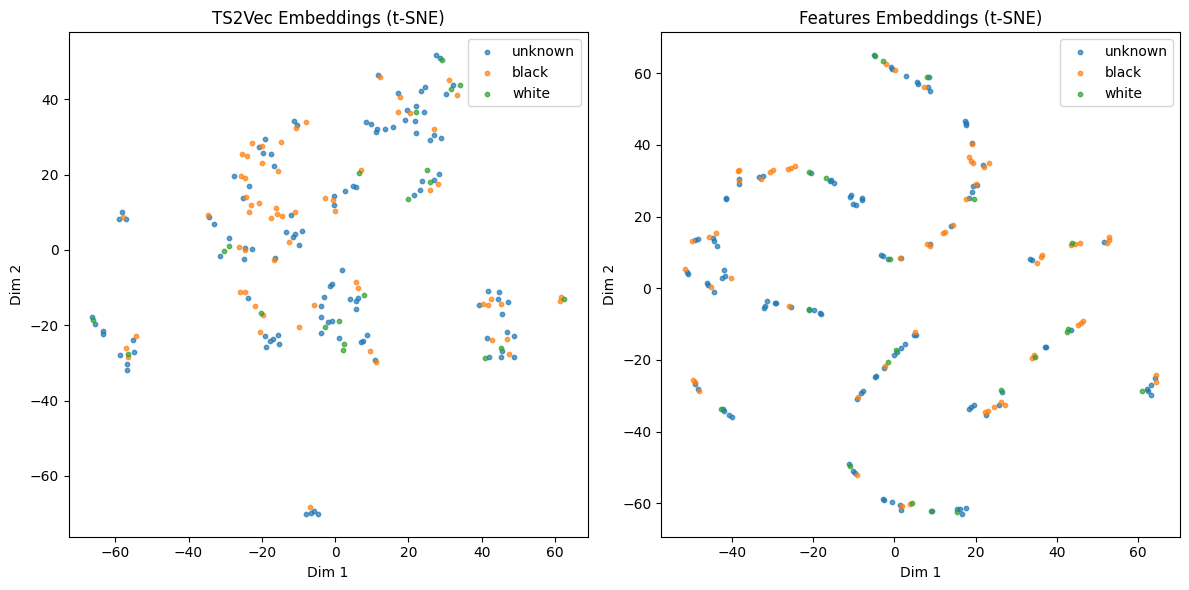

In [6]:
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

X_ts2vec_tsne = TSNE(
    n_components=2, learning_rate='auto', init='random', perplexity=3
).fit_transform(ts2vec_emb)

X_features_tsne = TSNE(
    n_components=2, learning_rate='auto', init='random', perplexity=3
).fit_transform(df_features.values)

fig, axes = plt.subplots(1, 2, figsize=(12, 6))
unique_labels = set(labels)

for label in unique_labels:
    idxs = [i for i, l in enumerate(labels) if l == label]
    axes[0].scatter(X_ts2vec_tsne[idxs, 0],  X_ts2vec_tsne[idxs, 1], label=label, s=10, alpha=0.7)
axes[0].set_title("TS2Vec Embeddings (t-SNE)")
axes[0].legend()
axes[0].set_xlabel("Dim 1")
axes[0].set_ylabel("Dim 2")

for label in unique_labels:
    idxs = [i for i, l in enumerate(labels) if l == label]
    axes[1].scatter(X_features_tsne[idxs, 0], X_features_tsne[idxs, 1], label=label, s=10, alpha=0.7)
axes[1].set_title("Features Embeddings (t-SNE)")
axes[1].legend()
axes[1].set_xlabel("Dim 1")
axes[1].set_ylabel("Dim 2")

plt.tight_layout()
plt.show()


OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


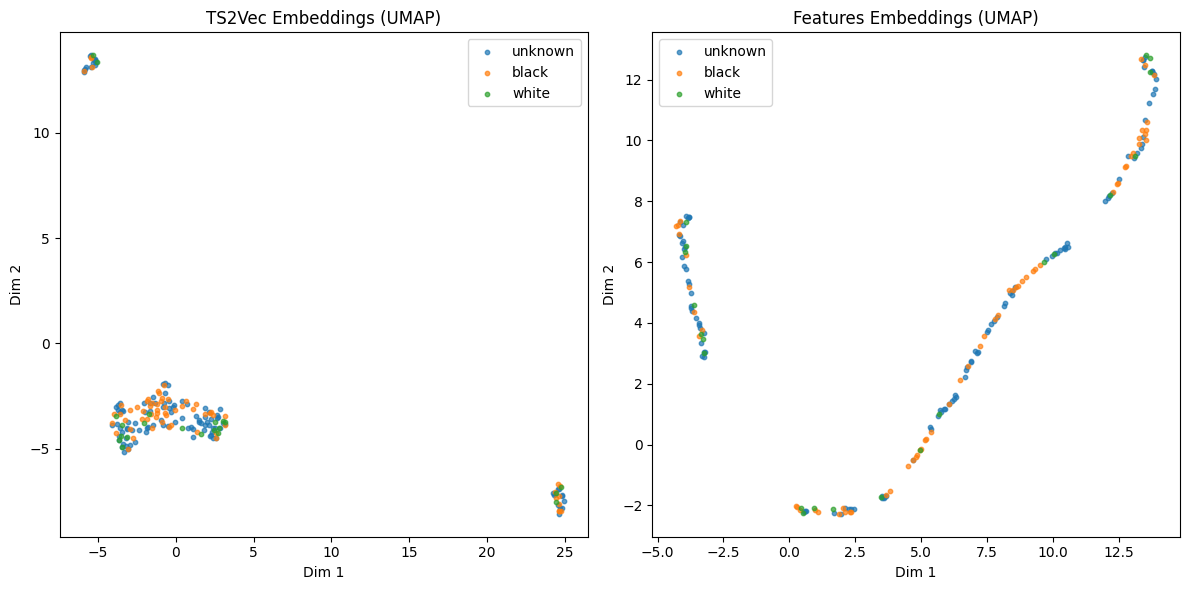

In [7]:
import matplotlib.pyplot as plt
import umap

X_ts2vec_umap = umap.UMAP(n_components=2).fit_transform(ts2vec_emb)
X_features_umap = umap.UMAP(n_components=2).fit_transform(df_features.values)

# Plot side by side
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

unique_labels = set(labels)

for label in unique_labels:
    idxs = [i for i, l in enumerate(labels) if l == label]
    axes[0].scatter(X_ts2vec_umap[idxs, 0],  X_ts2vec_umap[idxs, 1], label=label, s=10, alpha=0.7)
axes[0].set_title("TS2Vec Embeddings (UMAP)")
axes[0].legend()
axes[0].set_xlabel("Dim 1")
axes[0].set_ylabel("Dim 2")

for label in unique_labels:
    idxs = [i for i, l in enumerate(labels) if l == label]
    axes[1].scatter(X_features_umap[idxs, 0], X_features_umap[idxs, 1], label=label, s=10, alpha=0.7)
axes[1].set_title("Features Embeddings (UMAP)")
axes[1].legend()
axes[1].set_xlabel("Dim 1")
axes[1].set_ylabel("Dim 2")

plt.tight_layout()
plt.show()

In [8]:
import plotly.express as px

ts2vec_umap_3d = umap.UMAP(n_components=3).fit_transform(ts2vec_emb)

fig = px.scatter_3d(
    x=ts2vec_umap_3d[:, 0],
    y=ts2vec_umap_3d[:, 1],
    z=ts2vec_umap_3d[:, 2],
    opacity=0.7,
    size_max=5
)

fig.update_traces(marker=dict(size=3))  # smaller points for dense embeddings
fig.update_layout(
    title="UMAP 3D projection (interactive)",
    scene=dict(
        xaxis_title="Dim 1",
        yaxis_title="Dim 2",
        zaxis_title="Dim 3"
    )
)

fig.show()